### Calculate scoring rate + the probability distribution of time elapsed between scoring events

* work with one game first

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [34]:
sample = pd.read_csv (r"C:\Users\Bryant Xia\Desktop\lead_change_analysis\pbp_games\g201410290PHO.csv")
sample.head (10)

,time,away_description,away_change,score,home_change,home_description
0,11:43.0,,,0-2,+2,M. Plumlee makes 2-pt dunk at rim (assist by E...
1,11:28.0,K. Bryant misses 2-pt jump shot from 16 ft,,0-2,,
2,11:26.0,Offensive rebound by Team,,0-2,,
3,11:25.0,,,0-2,,Violation by M. Plumlee (def goaltending)
4,11:25.0,C. Boozer makes 2-pt layup from 2 ft (assist b...,+2,2-2,,
5,11:03.0,,,2-5,+3,M. Morris makes 3-pt jump shot from 23 ft (ass...
6,10:51.0,J. Lin misses 2-pt jump shot from 19 ft,,2-5,,
7,10:49.0,Offensive rebound by J. Hill,,2-5,,
8,10:43.0,C. Boozer misses 2-pt jump shot from 15 ft,,2-5,,
9,10:41.0,,,2-5,,Defensive rebound by M. Plumlee


* ignore OTs

In [59]:
quarter = [0]*len(sample)
quarter [0] = 1
qt_count = 1

for i in range (1, len(sample)):
    secs_prev = int (sample['time'][i-1].split(":")[0])*60+float (sample['time'][i-1].split(":")[1])
    secs_cur = int (sample['time'][i].split(":")[0])*60+float (sample['time'][i].split(":")[1])
    if (secs_cur - secs_prev >= 60): # no way 60s is added back on the clock
        print (sample['time'][i-1], sample['time'][i])
        qt_count +=1 
    quarter [i] = qt_count

sample ['quarter'] = quarter

In [55]:
sample ['seconds'] = sample.apply (lambda x: x.quarter*12*60 - int(x.time.split(":")[0])*60
                                             - float(x.time.split(":")[1]), axis = 1)

In [56]:
sample.tail ()

,time,away_description,away_change,score,home_change,home_description,quarter,seconds
419,0:39.0,,,99-119,,Turnover by T. Ennis (lost ball; steal by R. P...,4,2841.0
420,0:35.0,R. Price misses 2-pt jump shot from 4 ft (bloc...,,99-119,,,4,2845.0
421,0:35.0,Offensive rebound by Team,,99-119,,,4,2845.0
422,0:24.0,R. Price misses 2-pt layup from 2 ft,,99-119,,,4,2856.0
423,0:22.0,,,99-119,,Defensive rebound by A. Tolliver,4,2858.0


In [37]:
score_dict = {} #key = seconds, value = points scored
for i in range (1, 2881):
    score_dict [i] = 0

In [ ]:
for i in range (len(sample)):
    home_score = 0
    away_score = 0
    if (sample['home_change'][i][0] == "+"):
        home_score += int(sample['home_change'][i][1])
    if (sample['away_change'][i][0] == "+"):
        away_score += int(sample['away_change'][i][1])
    score_dict [sample['seconds'][i]] += home_score + away_score

---

In [223]:
def time (sample):

    quarter = [0]*len(sample)
    quarter [0] = 1
    qt_count = 1

    for i in range (1, len(sample)):
        secs_prev = int (sample['time'][i-1].split(":")[0])*60+float (sample['time'][i-1].split(":")[1])
        secs_cur = int (sample['time'][i].split(":")[0])*60+float (sample['time'][i].split(":")[1])
        if (secs_cur - secs_prev >= 60): # no way 60s is added back on the clock
            # print (sample['time'][i-1], sample['time'][i])
            qt_count +=1 
        quarter [i] = qt_count
    sample ['quarter'] = quarter
    sample ['seconds'] = sample.apply (lambda x: x.quarter*12*60 - int(x.time.split(":")[0])*60
                                             - float(x.time.split(":")[1]), axis = 1)
    sample = sample [sample['quarter']<=4]
    return sample

In [224]:
score_dict_home = [0]*2881
time_elapsed_home = [0]*2881
scoring_plays_home = [0]*2881
scoring_decomp_home = [0]*7

score_dict_away = [0]*2881
time_elapsed_away = [0]*2881
scoring_plays_away = [0]*2881
scoring_decomp_away = [0]*7

In [227]:
def stats_home (sample):

    prev_time = 0
    prev_value = 0

    #this would ignore the last scoring play; need to add a dummy row for home scoring
    sample.loc[len(sample)] = ['', '', '', '', '+10', '', 4, 3000] 

    for i in range (len(sample)):

        if (len(sample['home_change'][i])>0 and sample['home_change'][i][0] == "+"):

            if (int(sample['seconds'][i]) != 3000):
                delta = int(sample['home_change'][i][1])
                cur_time = int(sample['seconds'][i])
                score_dict_home [cur_time] += delta

            if (sample['seconds'][i] == prev_time):
                prev_value += delta
                
            else: #ignore the initial case
                if (prev_value>0):
                    time_elapsed_home [cur_time-int(prev_time)] += 1
                    scoring_decomp_home [prev_value] += 1
                    scoring_plays_home [int(prev_time)] += 1
                    
                prev_time = sample['seconds'][i]
                prev_value = delta

In [228]:
def stats_away (sample):

    prev_time = 0
    prev_value = 0

    #this would ignore the last scoring play; need to add a dummy row for away scoring
    sample.loc[len(sample)] = ['', '', '', '', '+10', '', 4, 3000] 

    for i in range (len(sample)):

        if (len(sample['away_change'][i])>0 and sample['away_change'][i][0] == "+"):

            if (int(sample['seconds'][i]) != 3000): 
                delta = int(sample['away_change'][i][1])
                cur_time = int(sample['seconds'][i])
                score_dict_away [cur_time] += delta

            if (sample['seconds'][i] == prev_time):
                prev_value += delta
                
            else: #ignore the initial case
                if (prev_value>0):
                    time_elapsed_away [cur_time-int(prev_time)] += 1
                    scoring_decomp_away [prev_value] += 1
                    scoring_plays_away [int(prev_time)] += 1
                    
                prev_time = sample['seconds'][i]
                prev_value = delta

In [229]:
games = pd.read_csv (r"C:\Users\Bryant Xia\Desktop\lead_change_analysis\game_schedule.csv")

In [230]:
for i in range (len(games)):
    if (i%100 == 0):
        print (str(int(i/100))+"%", end=" ")
    path = "g"+games['id'][i]+".csv"
    game = pd.read_csv (path)
    game = time (game)
    stats_home (game)
    game = pd.read_csv (path)
    game = time (game)
    stats_away (game)

0% 1% 2% 3% 4% 5% 6% 7% 8% 9% 10% 11% 12% 13% 14% 15% 16% 17% 18% 19% 20% 21% 22% 23% 24% 25% 26% 27% 28% 29% 30% 31% 32% 33% 34% 35% 36% 37% 38% 39% 40% 41% 42% 43% 44% 45% 46% 47% 48% 49% 50% 51% 52% 53% 54% 55% 56% 57% 58% 59% 60% 61% 62% 63% 64% 65% 66% 67% 68% 69% 70% 71% 72% 73% 74% 75% 76% 77% 78% 79% 80% 81% 82% 83% 84% 85% 86% 87% 88% 89% 90% 91% 92% 93% 94% 95% 96% 97% 98% 99% 100% 101% 

In [231]:
sec = []
for i in range (0, 2881):
    sec.append (i)

---
### Initial Look

In [232]:
scoring_plays_either = np.array(scoring_plays_home) + np.array(scoring_plays_away)
time_elapsed_either =  np.array(time_elapsed_home) +  np.array(time_elapsed_away)
scoring_decomp_tot =  np.array(scoring_decomp_home) +  np.array(scoring_decomp_away)

In [233]:
print (scoring_decomp_tot)

[     0  70473 663854 248741   1928     24      1]


In [234]:
scoring_time_prob = np.log (time_elapsed_either / np.sum(time_elapsed_either))

C:\Users\Bryant Xia\AppData\Local\Temp\ipykernel_17640\2910900034.py:1: RuntimeWarning: divide by zero encountered in log
  scoring_time_prob = np.log (time_elapsed_either / np.sum(time_elapsed_either))


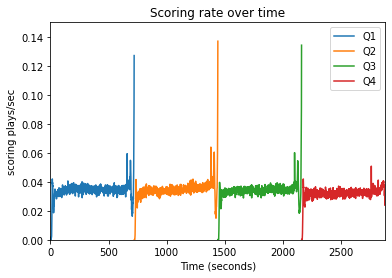

In [254]:
plt.title ("Scoring rate over time")
plt.ylim ([0, 0.15])
plt.xlim([0, 2880])
plt.plot (sec[0:721], (scoring_plays_either/len(games))[0:721], label ="Q1")
plt.plot (sec[721:1441], (scoring_plays_either/len(games))[721:1441], label ="Q2")
plt.plot (sec[1441:2161], (scoring_plays_either/len(games))[1441:2161], label ="Q3")
plt.plot (sec[2161:], (scoring_plays_either/len(games))[2161:], label ="Q4")
plt.legend ()
plt.xlabel ("Time (seconds)")
plt.ylabel ("scoring plays/sec")
plt.show ()

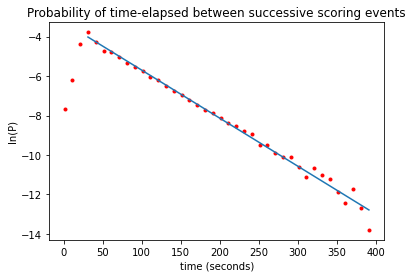

In [236]:
from sklearn.linear_model import LinearRegression

model = LinearRegression ()
X_fit = np.array (sec[31:400:10]).reshape (-1, 1)
Y_fit = np.array (scoring_time_prob[31:400:10]).reshape (-1, 1)
model.fit (X_fit, Y_fit)
y_pred = model.predict (np.array(sec[31:400:10]).reshape (-1, 1))

plt.title ("Probability of time-elapsed between successive scoring events")
plt.xlabel ("time (seconds)")
plt.ylabel ("ln(P)")
plt.scatter (sec[1:400:10], scoring_time_prob[1:400:10], marker=".", color="red")
plt.plot (sec[31:400:10], y_pred)
plt.show ()

* Linear on log scale -> exponential distribution of waiting time

In [237]:
scoring_decomp_pct = scoring_decomp_tot / np.sum (scoring_decomp_tot)
for i in range (1, len(scoring_decomp_pct)):
    print (i, "pts: ", str(scoring_decomp_pct [i]*100)+"%")

1 pts:  7.154466757561514%
2 pts:  67.39490833190358%
3 pts:  25.25235502593346%
4 pts:  0.19573186764546135%
5 pts:  0.002436496277744332%
6 pts:  0.00010152067823934719%


In [238]:
print ("scoring_rate: ",  np.mean(scoring_plays_either)/len(games))

scoring_rate:  0.03352971113288964


In [239]:
avg_pts = 0 

for i in range (1, len(scoring_decomp_pct)):
    avg_pts += i*scoring_decomp_pct [i]

print ("avg. points per scoring play: ",  avg_pts)

avg. points per scoring play:  2.1849706757520906
